In [1]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

SEED = 42

Wall time: 20.4 s


In [98]:
import xgboost as xgb

## Load Database/Import Data 

In [2]:
df = pd.read_csv("diamonds.csv")

In [3]:
df.sort_values('table')

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
11368,11369,1.04,Ideal,I,VS1,62.9,43.0,4997,6.45,6.41,4.04
35633,35634,0.29,Very Good,E,VS1,62.8,44.0,474,4.20,4.24,2.65
5979,5980,1.00,Fair,I,VS1,64.0,49.0,3951,6.43,6.39,4.10
22701,22702,0.30,Fair,E,SI1,64.5,49.0,630,4.28,4.25,2.75
25179,25180,2.00,Fair,H,SI1,61.2,50.0,13764,8.17,8.08,4.97
...,...,...,...,...,...,...,...,...,...,...,...
52861,52862,0.50,Fair,E,VS2,79.0,73.0,2579,5.21,5.18,4.09
52860,52861,0.50,Fair,E,VS2,79.0,73.0,2579,5.21,5.18,4.09
51342,51343,0.79,Fair,G,SI1,65.3,76.0,2362,5.52,5.13,3.35
50773,50774,0.81,Fair,F,SI2,68.8,79.0,2301,5.26,5.20,3.58


In [4]:
df.drop(df[['Unnamed: 0']],axis = 1, inplace = True)

In [5]:
#Drop x and z, who highly dependent on y, redundant
df.drop(df[['x']],axis = 1, inplace = True)
df.drop(df[['z']],axis = 1, inplace = True)

In [6]:
df = df[[c for c in df if c not in ['price']] + ['price']]
df.head()

,carat,cut,color,clarity,depth,table,y,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.98,326
1,0.21,Premium,E,SI1,59.8,61.0,3.84,326
2,0.23,Good,E,VS1,56.9,65.0,4.07,327
3,0.29,Premium,I,VS2,62.4,58.0,4.23,334
4,0.31,Good,J,SI2,63.3,58.0,4.35,335


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   y        53940 non-null  float64
 7   price    53940 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 3.3+ MB


In [8]:
#drop the rows with value 0 in x,y,z
#df = df.drop(df[df['x']==0].index)
df = df.drop(df[df['y']==0].index)
#df = df.drop(df[df['z']==0].index)

In [9]:
df.shape

(53933, 8)

In [10]:
df.isna().any().any()
# df.isna().sum()

False

In [11]:
#remove outliers
df = df[(df["table"]<75) & (df["table"] > 45)]
#remove outliers
df = df[(df["y"]<30)] 
#remove outliers
df = df[(df["depth"]<75)&(df["depth"]>45)] 


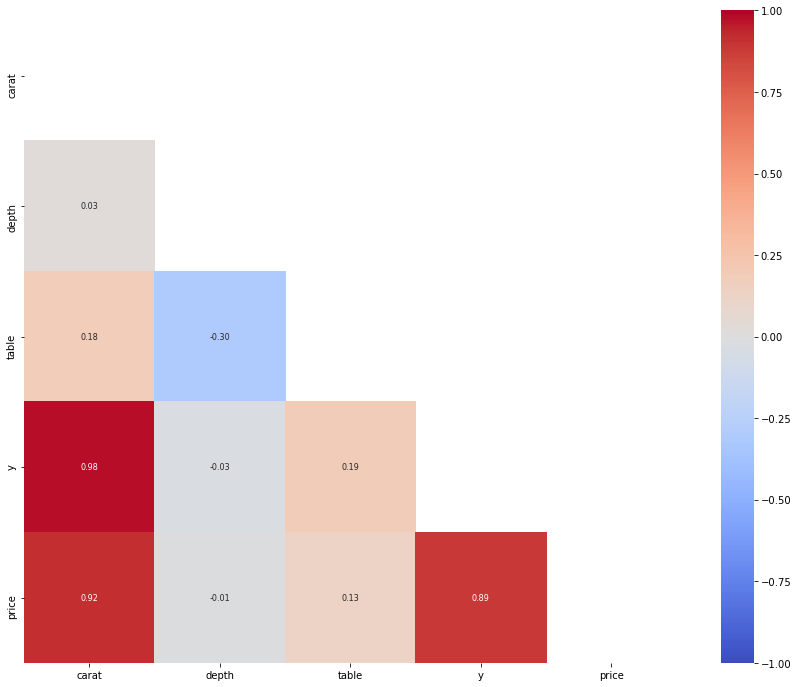

In [12]:
# Generate a mask for the upper triangle
matrix = np.triu(df.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(16,12))

# Plot the heatmap
_ = sns.heatmap(df.corr(), mask=matrix, annot=True, annot_kws={"size": 8}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f') 

Wall time: 2.74 s


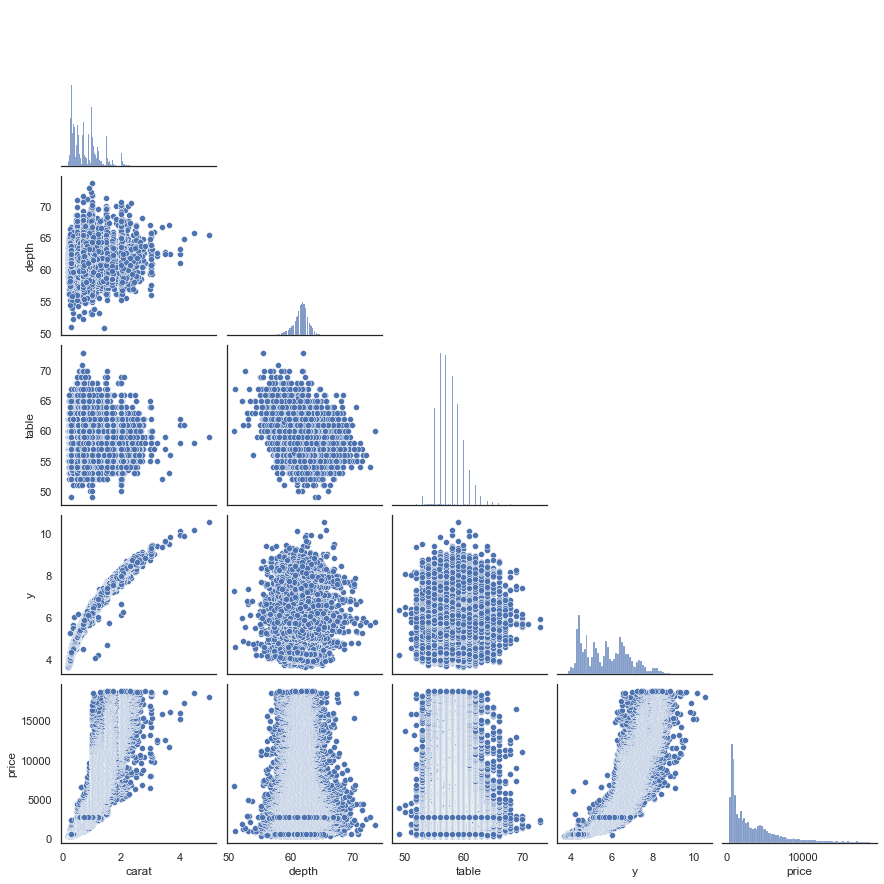

In [32]:
%%time
_ = sns.pairplot(df, corner=True, palette = 'inferno')
# correlation matrix heatmap visualization
sns.set(style="white")

In [13]:
# Encode variables with more than 2 Classes
df = pd.get_dummies(df, columns= [i for i in df.columns if df[i].dtypes=='object'],drop_first=True)

In [14]:
df = df[[c for c in df if c not in ['price']] + ['price']]
df.head()

,carat,depth,table,y,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
0,0.23,61.5,55.0,3.98,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,326
1,0.21,59.8,61.0,3.84,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,326
2,0.23,56.9,65.0,4.07,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,327
3,0.29,62.4,58.0,4.23,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,334
4,0.31,63.3,58.0,4.35,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,335


## Data Preprocessing/Feature Engineering

## Model Selection

### Split Data (Features/Target, Train/Validation/Testing)

In [15]:
X = df.drop(['price'], axis=1)
y = df['price']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

#### Feature Scaling (Normalization/Standardization)

In [17]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
X_test

array([[-0.88083756, -3.9070016 ,  1.60696614, ...,  1.843239  ,
        -0.27221974, -0.32366082],
       [ 1.47596744,  0.59461324, -1.10642673, ..., -0.54252324,
        -0.27221974, -0.32366082],
       [ 1.91786838,  0.24292458,  0.25026971, ..., -0.54252324,
        -0.27221974, -0.32366082],
       ...,
       [ 0.02400722, -1.79686964, -0.20196244, ..., -0.54252324,
        -0.27221974, -0.32366082],
       [-1.04918078,  0.10224912,  0.70250185, ..., -0.54252324,
        -0.27221974,  3.08965412],
       [-0.01807859, -0.24943954,  0.70250185, ..., -0.54252324,
        -0.27221974, -0.32366082]])

### Train a Model

In [107]:
results = []
names = []
scoring='r2'

In [108]:
%%time
lr_baseline = LinearRegression()
scores = cross_val_score(lr_baseline, X_train,y_train, scoring=scoring, cv=5,n_jobs=-1)
baseline_mean_score = scores.mean()
print("Baseline Model's score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
results.append(scores)
names.append('LR')

Baseline Model's score: 0.92 (avg) 0.00 (std)
Wall time: 26.3 s


In [109]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027])]

In [110]:
names

['LR']

### Evaluate Multiple Models and Select Best Model

In [111]:
%%time
KNNReg = KNeighborsRegressor()
scores = cross_val_score(KNNReg, X_train,  y_train, cv=5,  scoring=scoring)
msg = ("KNN Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('KNN')

KNN Mean score: 0.94 (avg) 0.00 (std)
Wall time: 33.6 s


In [112]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777])]

In [113]:
names

['LR', 'KNN']

In [114]:
%%time
MLPReg = MLPRegressor()
scores = cross_val_score(MLPReg, X_train,  y_train, cv=5,  scoring=scoring)
msg = ("MLPReg Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('MLP')

MLPReg Mean score: 0.96 (avg) 0.00 (std)
Wall time: 2min 45s


In [115]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777]),
 array([0.96283887, 0.9683675 , 0.96489754, 0.96430647, 0.96165621])]

In [116]:
names

['LR', 'KNN', 'MLP']

In [117]:
%%time
DT = DecisionTreeRegressor()
scores = cross_val_score(DT, X_train,  y_train, cv=3,  scoring=scoring)
msg = ("DT Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('DT')

DT Mean score: 0.95 (avg) 0.00 (std)
Wall time: 1.02 s


In [118]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777]),
 array([0.96283887, 0.9683675 , 0.96489754, 0.96430647, 0.96165621]),
 array([0.95331602, 0.94744034, 0.95415169])]

In [119]:
names

['LR', 'KNN', 'MLP', 'DT']

In [120]:
%%time
RF = RandomForestRegressor()
scores = cross_val_score(RF, X_train,  y_train, cv=3,  scoring=scoring)
msg = ("RF Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('RF')

RF Mean score: 0.97 (avg) 0.00 (std)
Wall time: 37.4 s


In [121]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777]),
 array([0.96283887, 0.9683675 , 0.96489754, 0.96430647, 0.96165621]),
 array([0.95331602, 0.94744034, 0.95415169]),
 array([0.97125926, 0.97194189, 0.9721208 ])]

In [122]:
names

['LR', 'KNN', 'MLP', 'DT', 'RF']

In [124]:
%%time
xg_reg = xgb.XGBRegressor()
scores = cross_val_score(xg_reg, X_train,  y_train, cv=3,  scoring=scoring)
msg = ("xg_reg Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
print(msg)
results.append(scores)
names.append('xg_reg')

xg_reg Mean score: 0.98 (avg) 0.00 (std)
Wall time: 5.85 s


In [125]:
results

[array([0.91357604, 0.92564848, 0.91872992, 0.9172607 , 0.91533027]),
 array([0.93629693, 0.9342846 , 0.93399841, 0.93909517, 0.93632777]),
 array([0.96283887, 0.9683675 , 0.96489754, 0.96430647, 0.96165621]),
 array([0.95331602, 0.94744034, 0.95415169]),
 array([0.97125926, 0.97194189, 0.9721208 ]),
 array([0.97646056, 0.97666684, 0.97654977])]

In [126]:
names

['LR', 'KNN', 'MLP', 'DT', 'RF', 'xg_reg']

In [90]:
# %%time
# SVReg = SVR()
# scores = cross_val_score(SVReg, X_train,  y_train, cv=3,  scoring=scoring)
# msg = ("SVR Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
# print(msg)
# results.append(scores)
# names.append('SVR')

SVR Mean score: 0.40 (avg) 0.01 (std)
Wall time: 5min 13s


In [167]:
# %%time
# NB = GaussianNB()
# scores = cross_val_score(NB, X_train,  y_train, cv=3,  scoring=scoring)
# msg = ("NB Mean score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))
# print(msg)
# results.append(scores)
# names.append('NB')

NB Mean score: 0.75 (avg) 0.01 (std)
Wall time: 2min 21s


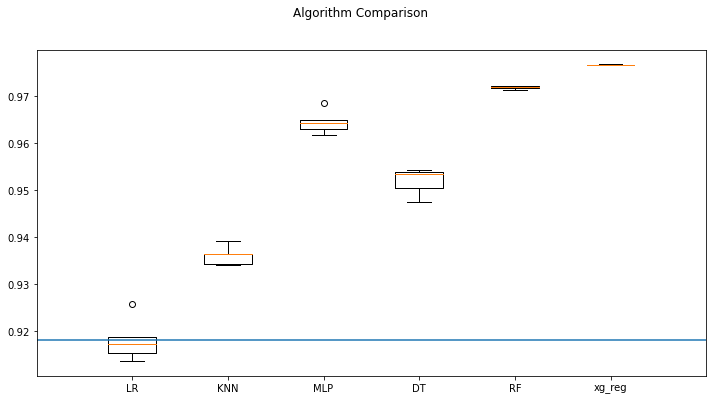

In [129]:
fig = plt.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.plot([-2,19], [baseline_mean_score, baseline_mean_score])
plt.xlim(0, 7)
plt.show()

### Hyperparameter Fine-tuning for final selected model # Random Forest

### Evaluate the fine-tuned Model (whether it will generalize well with unseen data - testing dataset)

In [19]:
%%time
# Hyperparameter fine-tuning for Random forest
parameters = {'n_estimators': [300, 500, 700],
              'max_depth': [5, None],
              'min_samples_split': [2, 3, 5]}
#               'min_samples_leaf': [2, 3, 4],
#               'max_features': ['sqrt', 'log2']}
    
gs_clf = GridSearchCV(RandomForestRegressor(random_state=SEED),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1)
_ = gs_clf.fit(X_train, y_train)


RandomForestRegressor(min_samples_split=3, n_estimators=700, random_state=42)
{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 700}
0.9738961888985889
Wall time: 30min 55s


In [33]:
final_clf = gs_clf.best_estimator_
print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)


RandomForestRegressor(min_samples_split=3, n_estimators=700, random_state=42)
{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 700}
0.9738961888985889


In [25]:
y_pred = final_clf.predict(X_test)

r2score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('Final Model (Random Forest) Metrics -')
print('\tR2 Score:', r2score)
print('\tMean Absolute Error:', mae)
print('\tMean Square Error:', mse)

Final Model (Random Forest) Metrics -
	R2 Score: 0.9754351483728942
	Mean Absolute Error: 297.6957578302264
	Mean Square Error: 383150.54828651086


## Post-mortem Analysis

In [26]:
# %%time
# rf = RandomForestRegressor(oob_score=True, n_jobs=-1, random_state=SEED)
# rf.fit(X_train, y_train)

In [27]:
own_pred = final_clf.predict(X_test)
for n in range(100):
    print("target value ",str(own_pred[n]), "VS", str(y_test.iloc[n]),"% as", (y_test.iloc[n]) / (own_pred[n])*100)
    n += 1

target value  820.8751258503399 VS 873 % as 106.34991517079581
target value  10716.770462585033 VS 9265 % as 86.45328396597154
target value  10766.64118367347 VS 11737 % as 109.0126419165708
target value  1060.930891156462 VS 1064 % as 100.28928452070922
target value  801.575273809524 VS 906 % as 113.02743854537735
target value  3390.4983503401354 VS 3527 % as 104.02600548813629
target value  3216.6167687074835 VS 2638 % as 82.01163488493576
target value  1169.0908333333336 VS 893 % as 76.38414180819994
target value  2314.892602040817 VS 2247 % as 97.06713814796579
target value  4639.336801020406 VS 4547 % as 98.00969826118042
target value  1031.2018197278912 VS 926 % as 89.79813478649102
target value  908.8116887755103 VS 795 % as 87.47686785049444
target value  612.6034047619048 VS 526 % as 85.86305526728762
target value  5583.9255544217685 VS 5637 % as 100.95048626742889
target value  1643.3916632653054 VS 1336 % as 81.29528887504884
target value  635.721380952381 VS 625 % as 98.313

In [34]:
import pickle

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53920 entries, 0 to 53939
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53920 non-null  float64
 1   depth          53920 non-null  float64
 2   table          53920 non-null  float64
 3   y              53920 non-null  float64
 4   cut_Good       53920 non-null  uint8  
 5   cut_Ideal      53920 non-null  uint8  
 6   cut_Premium    53920 non-null  uint8  
 7   cut_Very Good  53920 non-null  uint8  
 8   color_E        53920 non-null  uint8  
 9   color_F        53920 non-null  uint8  
 10  color_G        53920 non-null  uint8  
 11  color_H        53920 non-null  uint8  
 12  color_I        53920 non-null  uint8  
 13  color_J        53920 non-null  uint8  
 14  clarity_IF     53920 non-null  uint8  
 15  clarity_SI1    53920 non-null  uint8  
 16  clarity_SI2    53920 non-null  uint8  
 17  clarity_VS1    53920 non-null  uint8  
 18  clarit

In [88]:
#simulating an user input values
X_UsrInput = [[0.1, 50, 50, 4, 0,0,0,1,1,0,0,0,0,0, 1,0,0,0,0,0,0]]

In [89]:
#pass the value into scaler and dump into a file.
filename = 'diamond_Price_Prediction_scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

#load the file and save the result as variable
loaded_scaler = pickle.load(open(filename, 'rb'))
scaler_result = loaded_scaler.transform(X_UsrInput)
print(scaler_result)


[[-1.47003881 -8.26794098 -3.36758745 -1.55673449 -0.31666994 -0.81768689
  -0.58248999  1.85696542  2.13072689 -0.46266927 -0.51231612 -0.42970432
  -0.33610345 -0.23453986  5.46690684 -0.56613178 -0.44948661 -0.42232507
  -0.54252324 -0.27221974 -0.32366082]]


In [90]:
#dump the 
filename = 'diamond_Price_Prediction_model.sav'
pickle.dump(final_clf, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
# some time later...
 

[611.8242517]


In [93]:
result = loaded_model.predict(scaler_result)
print(result)


[611.8242517]


In [80]:
n = 101
X_test[n]

array([-0.2074647 ,  0.17258685, -1.10642673, -0.05783164, -0.31666994,
        1.22296201, -0.58248999, -0.53851299, -0.46932341,  2.16137113,
       -0.51231612, -0.42970432, -0.33610345, -0.23453986, -0.18291879,
       -0.56613178, -0.44948661, -0.42232507, -0.54252324, -0.27221974,
        3.08965412])

In [81]:
loaded_model = pickle.load(open(filename, 'rb'))
user_input = X_test[[n]]
user_pred = loaded_model.predict(user_input)
print(user_pred)


[3058.75]


In [95]:
y_test.iloc[n]

3191

In [73]:
type(X_test)

numpy.ndarray

In [33]:
# Creating the feature importances dataframe
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X.columns)

feat_imp = pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
feat_imp_sorted = feat_imp.sort_values('feature_importance', ascending=False)

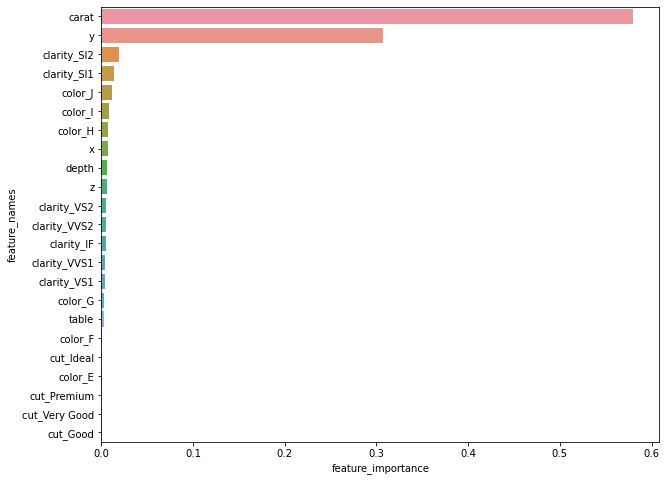

In [34]:
plt.figure(figsize=(10,8))
_ = sns.barplot(x=feat_imp_sorted['feature_importance'], y=feat_imp_sorted['feature_names'])

NameError: name 'plt' is not defined